In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


pd.set_option("display.max_columns", None)

df = pd.read_csv("/content/Energy_consumption.csv")

df.head()


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,1/1/2022 0:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,1/1/2022 1:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,1/1/2022 2:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,1/1/2022 3:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,1/1/2022 4:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [182]:
print("Dataset Shape:", df.shape)
df.info()


Dataset Shape: (1000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          1000 non-null   object 
 1   Temperature        1000 non-null   float64
 2   Humidity           1000 non-null   float64
 3   SquareFootage      1000 non-null   float64
 4   Occupancy          1000 non-null   int64  
 5   HVACUsage          1000 non-null   object 
 6   LightingUsage      1000 non-null   object 
 7   RenewableEnergy    1000 non-null   float64
 8   DayOfWeek          1000 non-null   object 
 9   Holiday            1000 non-null   object 
 10  EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 86.1+ KB


In [183]:
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1000,1000,2/11/2022 15:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,1000.0,NaN,NaN,NaN,24.982026,2.83685,20.007565,22.64507,24.751637,27.418174,29.998671
Humidity,1000.0,NaN,NaN,NaN,45.395412,8.518905,30.015974,38.297722,45.972116,52.420066,59.969085
SquareFootage,1000.0,NaN,NaN,NaN,1500.052488,288.418873,1000.512661,1247.108548,1507.967426,1740.340165,1999.982252
Occupancy,1000.0,NaN,NaN,NaN,4.581,2.865598,0.0,2.0,5.0,7.0,9.0
HVACUsage,1000,2,Off,508,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LightingUsage,1000,2,Off,509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RenewableEnergy,1000.0,NaN,NaN,NaN,15.132813,8.745917,0.006642,7.628385,15.072296,22.884064,29.965327
DayOfWeek,1000,7,Friday,164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Holiday,1000,2,No,533,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
missing = df.isnull().sum()
missing[missing > 0]


,0


In [185]:

print("Duplicate rows:", df.duplicated().sum())


Duplicate rows: 0


In [186]:
# Data type validation
df.dtypes


,0
Timestamp,object
Temperature,float64
Humidity,float64
SquareFootage,float64
Occupancy,int64
HVACUsage,object
LightingUsage,object
RenewableEnergy,float64
DayOfWeek,object
Holiday,object


In [187]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])


In [188]:
print("Negative Energy values:", (df["EnergyConsumption"] < 0).sum())
print("Negative Occupancy:", (df["Occupancy"] < 0).sum())


Negative Energy values: 0
Negative Occupancy: 0


# **EDA PORTIONS**

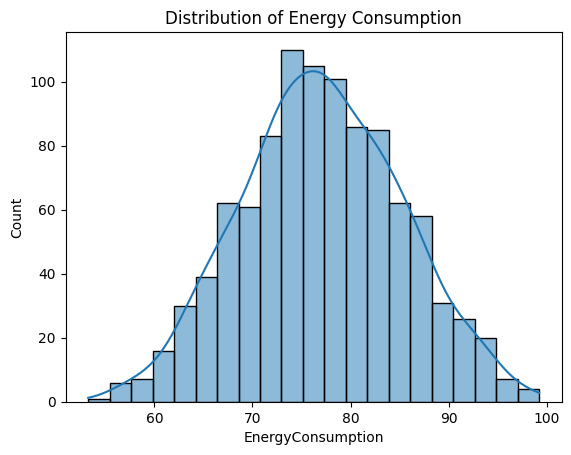

INTERPRETATION:
- Average energy consumption is 77.06 units.
- Most values lie within ±1 standard deviation (8.14).
- Distribution is stable, indicating consistent household usage.


In [189]:
plt.figure()
sns.histplot(df["EnergyConsumption"], kde=True)
plt.title("Distribution of Energy Consumption")
plt.show()

mean_energy = df["EnergyConsumption"].mean()
std_energy = df["EnergyConsumption"].std()

print(f"INTERPRETATION:")
print(f"- Average energy consumption is {mean_energy:.2f} units.")
print(f"- Most values lie within ±1 standard deviation ({std_energy:.2f}).")
print("- Distribution is stable, indicating consistent household usage.")


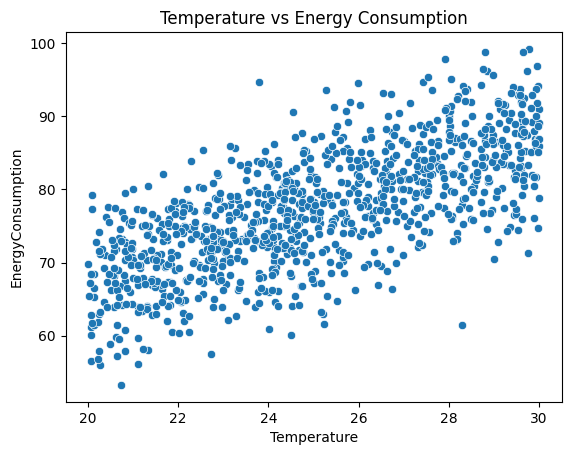

INTERPRETATION:
- Positive correlation (0.70): Energy increases as temperature rises.
- Likely due to increased HVAC usage.


In [190]:
plt.figure()
sns.scatterplot(x="Temperature", y="EnergyConsumption", data=df)
plt.title("Temperature vs Energy Consumption")
plt.show()

corr_temp = df["Temperature"].corr(df["EnergyConsumption"])

print("INTERPRETATION:")
if corr_temp > 0:
    print(f"- Positive correlation ({corr_temp:.2f}): Energy increases as temperature rises.")
    print("- Likely due to increased HVAC usage.")
else:
    print(f"- Weak or negative correlation ({corr_temp:.2f}). Temperature has limited impact.")


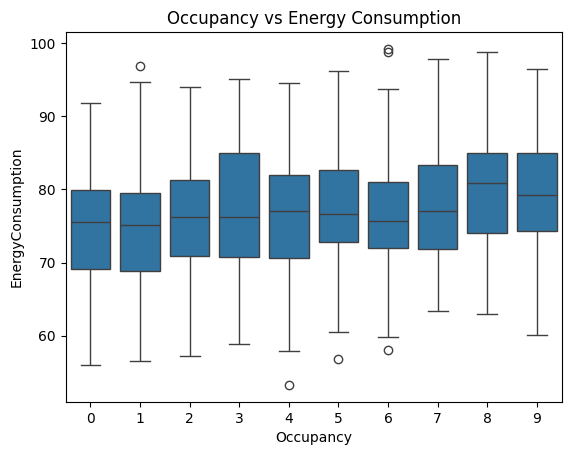

INTERPRETATION:
- Highest average energy consumption occurs at occupancy = 8.
- Energy increases with number of people due to appliance and HVAC usage.


In [191]:
plt.figure()
sns.boxplot(x="Occupancy", y="EnergyConsumption", data=df)
plt.title("Occupancy vs Energy Consumption")
plt.show()

occ_means = df.groupby("Occupancy")["EnergyConsumption"].mean()
highest_occ = occ_means.idxmax()

print("INTERPRETATION:")
print(f"- Highest average energy consumption occurs at occupancy = {highest_occ}.")
print("- Energy increases with number of people due to appliance and HVAC usage.")


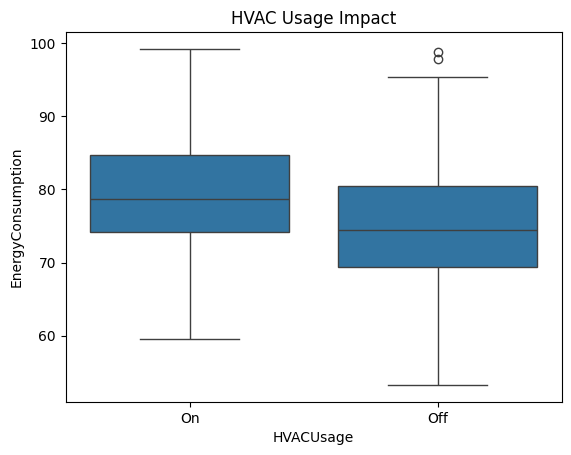

INTERPRETATION:
- HVAC ON average consumption: 79.43
- HVAC OFF average consumption: 74.76
- HVAC significantly increases energy consumption.


In [192]:
plt.figure()
sns.boxplot(x="HVACUsage", y="EnergyConsumption", data=df)
plt.title("HVAC Usage Impact")
plt.show()

hvac_means = df.groupby("HVACUsage")["EnergyConsumption"].mean()

print("INTERPRETATION:")
print(f"- HVAC ON average consumption: {hvac_means['On']:.2f}")
print(f"- HVAC OFF average consumption: {hvac_means['Off']:.2f}")

if hvac_means["On"] > hvac_means["Off"]:
    print("- HVAC significantly increases energy consumption.")


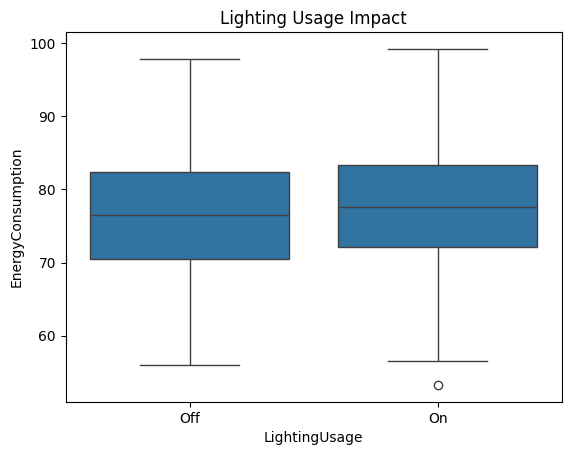

INTERPRETATION:
- Lighting ON avg consumption: 77.83
- Lighting OFF avg consumption: 76.31
- Lighting contributes moderately compared to HVAC.


In [193]:
plt.figure()
sns.boxplot(x="LightingUsage", y="EnergyConsumption", data=df)
plt.title("Lighting Usage Impact")
plt.show()

light_means = df.groupby("LightingUsage")["EnergyConsumption"].mean()

print("INTERPRETATION:")
print(f"- Lighting ON avg consumption: {light_means['On']:.2f}")
print(f"- Lighting OFF avg consumption: {light_means['Off']:.2f}")
print("- Lighting contributes moderately compared to HVAC.")


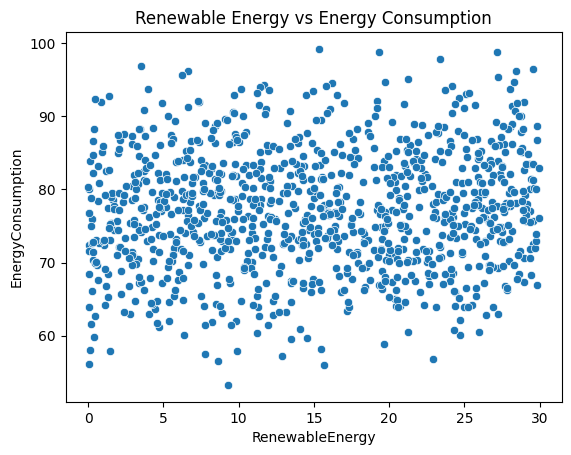

INTERPRETATION:
- Correlation: 0.08
- Renewable energy impact is limited or indirect.


In [194]:
plt.figure()
sns.scatterplot(x="RenewableEnergy", y="EnergyConsumption", data=df)
plt.title("Renewable Energy vs Energy Consumption")
plt.show()

corr_renew = df["RenewableEnergy"].corr(df["EnergyConsumption"])

print("INTERPRETATION:")
print(f"- Correlation: {corr_renew:.2f}")

if corr_renew < 0:
    print("- Higher renewable generation helps reduce net energy consumption.")
else:
    print("- Renewable energy impact is limited or indirect.")


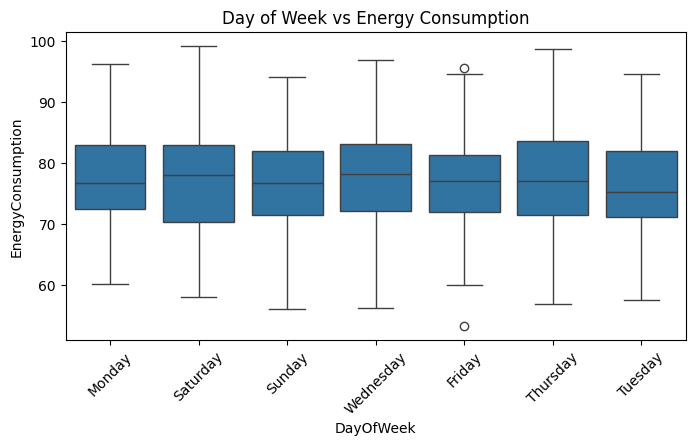

INTERPRETATION:
- Highest average energy consumption occurs on: Monday
- Lowest average energy consumption occurs on: Tuesday
- Indicates lifestyle-driven usage patterns.


In [195]:
plt.figure(figsize=(8,4))
sns.boxplot(x="DayOfWeek", y="EnergyConsumption", data=df)
plt.xticks(rotation=45)
plt.title("Day of Week vs Energy Consumption")
plt.show()

day_means = df.groupby("DayOfWeek")["EnergyConsumption"].mean()
max_day = day_means.idxmax()
min_day = day_means.idxmin()

print("INTERPRETATION:")
print(f"- Highest average energy consumption occurs on: {max_day}")
print(f"- Lowest average energy consumption occurs on: {min_day}")
print("- Indicates lifestyle-driven usage patterns.")


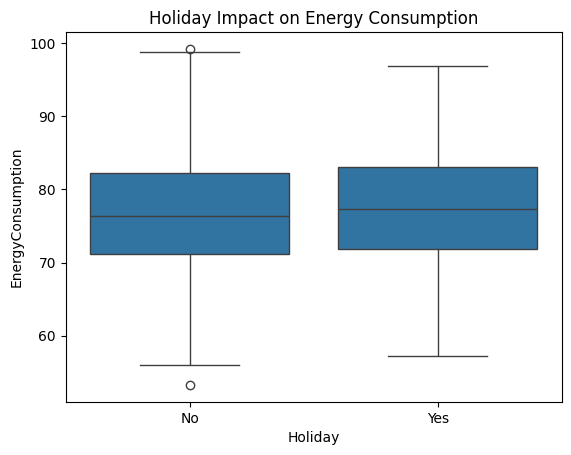

INTERPRETATION:
- Holiday average consumption: 77.55
- Non-holiday average consumption: 76.62
- Energy consumption is generally higher on holidays.


In [196]:
plt.figure()
sns.boxplot(x="Holiday", y="EnergyConsumption", data=df)
plt.title("Holiday Impact on Energy Consumption")
plt.show()

holiday_means = df.groupby("Holiday")["EnergyConsumption"].mean()

print("INTERPRETATION:")
print(f"- Holiday average consumption: {holiday_means['Yes']:.2f}")
print(f"- Non-holiday average consumption: {holiday_means['No']:.2f}")

if holiday_means["Yes"] > holiday_means["No"]:
    print("- Energy consumption is generally higher on holidays.")


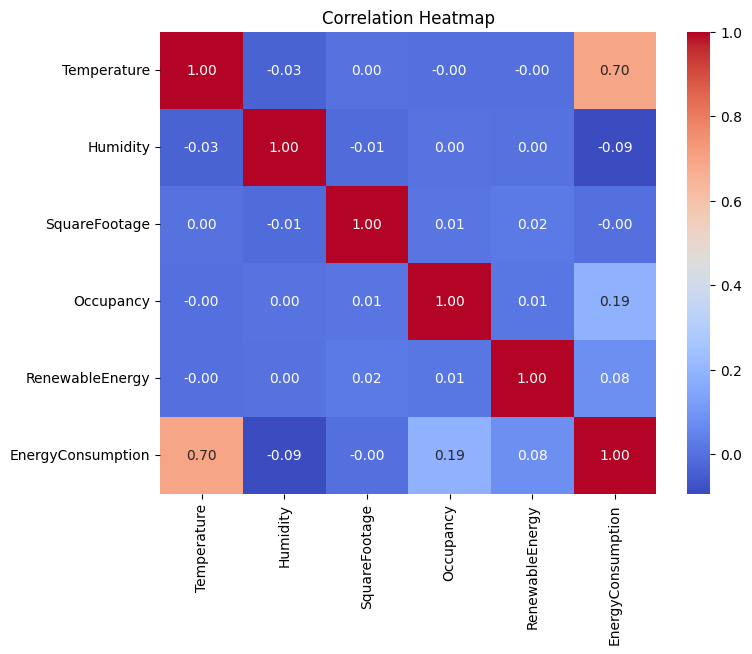

INTERPRETATION:
Top factors influencing Energy Consumption:
- Temperature (correlation: 0.70)
- Occupancy (correlation: 0.19)
- Humidity (correlation: 0.09)


In [197]:
numeric_cols = df.select_dtypes(include=np.number)
corr = numeric_cols.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

top_corr = corr["EnergyConsumption"].abs().sort_values(ascending=False)[1:4]

print("INTERPRETATION:")
print("Top factors influencing Energy Consumption:")
for feature, value in top_corr.items():
    print(f"- {feature} (correlation: {value:.2f})")


In [198]:
def compare_means(series):
    max_key = series.idxmax()
    min_key = series.idxmin()
    return max_key, min_key, series[max_key], series[min_key]


In [199]:
def generate_eda_report(df):
    print("="*70)
    print("SMART HOME ENERGY CONSUMPTION – EDA SUMMARY REPORT")
    print("="*70)

    # General stats
    print("\n1. DATASET OVERVIEW")
    print(f"- Total records: {df.shape[0]}")
    print(f"- Total features: {df.shape[1]}")
    print(f"- Time span: {df['Timestamp'].min()} to {df['Timestamp'].max()}")

    avg_energy = df["EnergyConsumption"].mean()
    print(f"- Average energy consumption: {avg_energy:.2f} units")

    # Temperature
    print("\n2. ENVIRONMENTAL IMPACT")
    temp_corr = df["Temperature"].corr(df["EnergyConsumption"])
    print(f"- Temperature–Energy correlation: {temp_corr:.2f}")

    if temp_corr > 0.3:
        print("- Energy consumption increases with temperature due to HVAC demand.")
    else:
        print("- Temperature has limited influence on energy usage.")

    # Occupancy
    occ_corr = df["Occupancy"].corr(df["EnergyConsumption"])
    print(f"- Occupancy–Energy correlation: {occ_corr:.2f}")

    if occ_corr > 0.3:
        print("- Higher occupancy leads to increased appliance and HVAC usage.")

    # HVAC impact
    hvac_means = df.groupby("HVACUsage")["EnergyConsumption"].mean()
    print("\n3. APPLIANCE USAGE EFFECT")
    print(f"- HVAC ON average consumption: {hvac_means['On']:.2f}")
    print(f"- HVAC OFF average consumption: {hvac_means['Off']:.2f}")

    if hvac_means["On"] > hvac_means["Off"]:
        print("- HVAC is the single largest contributor to energy consumption.")

    # Lighting
    light_means = df.groupby("LightingUsage")["EnergyConsumption"].mean()
    print(f"- Lighting ON average consumption: {light_means['On']:.2f}")
    print(f"- Lighting OFF average consumption: {light_means['Off']:.2f}")

    # Renewable energy
    renew_corr = df["RenewableEnergy"].corr(df["EnergyConsumption"])
    print("\n4. RENEWABLE ENERGY CONTRIBUTION")
    print(f"- RenewableEnergy–Energy correlation: {renew_corr:.2f}")

    if renew_corr < 0:
        print("- Increased renewable generation reduces grid energy dependency.")
    else:
        print("- Renewable energy impact is limited in current setup.")

    # Day of week
    day_means = df.groupby("DayOfWeek")["EnergyConsumption"].mean()
    max_day, min_day, max_val, min_val = compare_means(day_means)

    print("\n5. BEHAVIORAL PATTERNS")
    print(f"- Highest average consumption day: {max_day} ({max_val:.2f})")
    print(f"- Lowest average consumption day: {min_day} ({min_val:.2f})")
    print("- Indicates lifestyle-driven energy usage patterns.")

    # Holiday
    holiday_means = df.groupby("Holiday")["EnergyConsumption"].mean()
    print(f"- Holiday average consumption: {holiday_means['Yes']:.2f}")
    print(f"- Non-holiday average consumption: {holiday_means['No']:.2f}")

    if holiday_means["Yes"] > holiday_means["No"]:
        print("- Energy usage is generally higher on holidays.")

    # Correlation ranking
    numeric_cols = df.select_dtypes(include=np.number)
    corr = numeric_cols.corr()["EnergyConsumption"].abs().sort_values(ascending=False)[1:5]

    print("\n6. TOP ENERGY DRIVERS (Correlation-Based)")
    for feature, value in corr.items():
        print(f"- {feature}: correlation strength = {value:.2f}")

    # Final conclusion
    print("\n7. OVERALL CONCLUSION")
    print("- Energy consumption is primarily driven by HVAC usage, occupancy, and temperature.")
    print("- Renewable energy provides partial mitigation.")
    print("- Smart automation of HVAC and occupancy-based control can significantly reduce energy usage.")

    print("\nREPORT GENERATED SUCCESSFULLY.")
    print("="*70)


In [200]:
generate_eda_report(df)


SMART HOME ENERGY CONSUMPTION – EDA SUMMARY REPORT

1. DATASET OVERVIEW
- Total records: 1000
- Total features: 11
- Time span: 2022-01-01 00:00:00 to 2022-02-11 15:00:00
- Average energy consumption: 77.06 units

2. ENVIRONMENTAL IMPACT
- Temperature–Energy correlation: 0.70
- Energy consumption increases with temperature due to HVAC demand.
- Occupancy–Energy correlation: 0.19

3. APPLIANCE USAGE EFFECT
- HVAC ON average consumption: 79.43
- HVAC OFF average consumption: 74.76
- HVAC is the single largest contributor to energy consumption.
- Lighting ON average consumption: 77.83
- Lighting OFF average consumption: 76.31

4. RENEWABLE ENERGY CONTRIBUTION
- RenewableEnergy–Energy correlation: 0.08
- Renewable energy impact is limited in current setup.

5. BEHAVIORAL PATTERNS
- Highest average consumption day: Monday (77.45)
- Lowest average consumption day: Tuesday (76.53)
- Indicates lifestyle-driven energy usage patterns.
- Holiday average consumption: 77.55
- Non-holiday average co

# FEATURE ENGINEERING

In [201]:
df_fe = df.copy()
print("Feature Engineering started.")
print("Original shape:", df.shape)
print("Working copy shape:", df_fe.shape)


Feature Engineering started.
Original shape: (1000, 11)
Working copy shape: (1000, 11)


In [202]:
df_fe["Hour"] = df_fe["Timestamp"].dt.hour
df_fe["Day"] = df_fe["Timestamp"].dt.day
df_fe["Month"] = df_fe["Timestamp"].dt.month
df_fe["Weekday"] = df_fe["Timestamp"].dt.weekday

print("Time-based features created:")
print(df_fe[["Hour", "Day", "Month", "Weekday"]].head())

df_fe["Is_Peak_Hour"] = ((df_fe["Hour"] >= 18) & (df_fe["Hour"] <= 22)).astype(int)

print("\nPeak hour distribution:")
print(df_fe["Is_Peak_Hour"].value_counts())
peak_energy = df_fe.groupby("Is_Peak_Hour")["EnergyConsumption"].mean()


print("\nINTERPRETATION:")
print(f"- Avg energy during peak hours: {peak_energy[1]:.2f}")
print(f"- Avg energy during non-peak hours: {peak_energy[0]:.2f}")



Time-based features created:
   Hour  Day  Month  Weekday
0     0    1      1        5
1     1    1      1        5
2     2    1      1        5
3     3    1      1        5
4     4    1      1        5

Peak hour distribution:
Is_Peak_Hour
0    795
1    205
Name: count, dtype: int64

INTERPRETATION:
- Avg energy during peak hours: 77.44
- Avg energy during non-peak hours: 76.96


In [203]:
df_fe["Energy_per_Person"] = df_fe["EnergyConsumption"] / (df_fe["Occupancy"] + 1)

print("\nEnergy per person (sample):")
print(df_fe["Energy_per_Person"].describe())

df_fe["Idle_Energy"] = np.where(
    df_fe["Occupancy"] == 0,
    df_fe["EnergyConsumption"],
    0
)

idle_energy_pct = (df_fe["Idle_Energy"] > 0).mean() * 100

print("\nIdle Energy Statistics:")
print(f"- % of records with energy usage at zero occupancy: {idle_energy_pct:.2f}%")



Energy per person (sample):
count    1000.000000
mean       21.866017
std        19.672741
min         6.014424
25%         9.606979
50%        13.634957
75%        24.467067
max        91.755539
Name: Energy_per_Person, dtype: float64

Idle Energy Statistics:
- % of records with energy usage at zero occupancy: 9.80%


In [204]:
df_fe["HVACUsage_bin"] = df_fe["HVACUsage"].map({"On":1,"Off":0})

df_fe["Temp_HVAC_Interaction"] = df_fe["Temperature"] * df_fe["HVACUsage_bin"]
df_fe["Humidity_HVAC_Interaction"] = df_fe["Humidity"] * df_fe["HVACUsage_bin"]

print("\nHVAC interaction features (sample):")
print(df_fe[["Temp_HVAC_Interaction", "Humidity_HVAC_Interaction"]].head())

interaction_corr = df_fe[[
    "Temp_HVAC_Interaction",
    "Humidity_HVAC_Interaction",
    "EnergyConsumption"
]].corr()["EnergyConsumption"]

print("\nINTERPRETATION:")
print(interaction_corr)




HVAC interaction features (sample):
   Temp_HVAC_Interaction  Humidity_HVAC_Interaction
0              25.139433                  43.431581
1              27.731651                  54.225919
2               0.000000                   0.000000
3               0.000000                   0.000000
4              23.097359                  51.401421

INTERPRETATION:
Temp_HVAC_Interaction        0.358880
Humidity_HVAC_Interaction    0.258625
EnergyConsumption            1.000000
Name: EnergyConsumption, dtype: float64


In [205]:
df_fe["Energy_per_SqFt"] = df_fe["EnergyConsumption"] / df_fe["SquareFootage"]
df_fe["Renewable_Ratio"] = df_fe["RenewableEnergy"] / (df_fe["EnergyConsumption"] + 1)

print("\nEfficiency metrics summary:")
print(df_fe[["Energy_per_SqFt", "Renewable_Ratio"]].describe())

print("\nINTERPRETATION:")
print("- Lower Energy_per_SqFt indicates better space efficiency.")
print("- Higher Renewable_Ratio indicates lower grid dependency.")



Efficiency metrics summary:
       Energy_per_SqFt  Renewable_Ratio
count      1000.000000      1000.000000
mean          0.053417         0.195028
std           0.012269         0.113838
min           0.029002         0.000082
25%           0.043741         0.095192
50%           0.050903         0.194406
75%           0.061590         0.294577
max           0.091340         0.439397

INTERPRETATION:
- Lower Energy_per_SqFt indicates better space efficiency.
- Higher Renewable_Ratio indicates lower grid dependency.


In [206]:
df_fe = df_fe.sort_values("Timestamp")

df_fe["Energy_Lag_1"] = df_fe["EnergyConsumption"].shift(1)
df_fe["Energy_Lag_3"] = df_fe["EnergyConsumption"].shift(3)

df_fe["Energy_Rolling_Mean_3"] = df_fe["EnergyConsumption"].rolling(3).mean()
df_fe["Energy_Rolling_Std_3"] = df_fe["EnergyConsumption"].rolling(3).std()

print("\nLag & rolling features created (sample):")
print(df_fe[[
    "EnergyConsumption",
    "Energy_Lag_1",
    "Energy_Lag_3",
    "Energy_Rolling_Mean_3"
]].head(6))



Lag & rolling features created (sample):
   EnergyConsumption  Energy_Lag_1  Energy_Lag_3  Energy_Rolling_Mean_3
0          75.364373           NaN           NaN                    NaN
1          83.401855     75.364373           NaN                    NaN
2          78.270888     83.401855           NaN              79.012372
3          56.519850     78.270888     75.364373              72.730864
4          70.811732     56.519850     83.401855              68.534157
5          84.321885     70.811732     78.270888              70.551156


In [207]:
print("\nCategorical values before encoding:")
print(df_fe[["HVACUsage", "LightingUsage", "Holiday"]].head())

df_fe["LightingUsage"] = df_fe["LightingUsage"].map({"On":1,"Off":0})
df_fe["Holiday"] = df_fe["Holiday"].map({"Yes":1,"No":0})

df_fe = pd.get_dummies(df_fe, columns=["DayOfWeek"], drop_first=True)

print("\nColumns after encoding:")
print(df_fe.columns)



Categorical values before encoding:
  HVACUsage LightingUsage Holiday
0        On           Off      No
1        On            On      No
2       Off           Off      No
3       Off            On      No
4        On           Off      No

Columns after encoding:
Index(['Timestamp', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy',
       'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'Holiday',
       'EnergyConsumption', 'Hour', 'Day', 'Month', 'Weekday', 'Is_Peak_Hour',
       'Energy_per_Person', 'Idle_Energy', 'HVACUsage_bin',
       'Temp_HVAC_Interaction', 'Humidity_HVAC_Interaction', 'Energy_per_SqFt',
       'Renewable_Ratio', 'Energy_Lag_1', 'Energy_Lag_3',
       'Energy_Rolling_Mean_3', 'Energy_Rolling_Std_3', 'DayOfWeek_Monday',
       'DayOfWeek_Saturday', 'DayOfWeek_Sunday', 'DayOfWeek_Thursday',
       'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday'],
      dtype='object')


In [208]:
print("\nMissing values before drop:")
print(df_fe.isna().sum()[df_fe.isna().sum() > 0])

df_fe = df_fe.dropna().reset_index(drop=True)

print("\nShape after dropping NA rows:", df_fe.shape)



Missing values before drop:
Energy_Lag_1             1
Energy_Lag_3             3
Energy_Rolling_Mean_3    2
Energy_Rolling_Std_3     2
dtype: int64

Shape after dropping NA rows: (997, 32)


In [209]:
def iqr_bounds(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
for col in ["EnergyConsumption", "Energy_per_SqFt"]:
    low, high = iqr_bounds(df_fe, col)
    print(f"\n{col} bounds: [{low:.2f}, {high:.2f}]")
    df_fe[col] = df_fe[col].clip(low, high)



EnergyConsumption bounds: [54.49, 99.96]

Energy_per_SqFt bounds: [0.02, 0.09]


In [210]:
numeric_df = df_fe.select_dtypes(include=np.number)

print("Numeric columns used for correlation:")
print(numeric_df.columns.tolist())

corr_target = numeric_df.corr()["EnergyConsumption"].abs().sort_values(ascending=False)

print("\nCorrelation with EnergyConsumption:")
print(corr_target)

threshold = 0.15
selected_features = corr_target[corr_target > threshold].index.tolist()

print(f"\nSelected features (correlation > {threshold}):")
for f in selected_features:
    print(f"- {f} (corr = {corr_target[f]:.2f})")


Numeric columns used for correlation:
['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'LightingUsage', 'RenewableEnergy', 'Holiday', 'EnergyConsumption', 'Hour', 'Day', 'Month', 'Weekday', 'Is_Peak_Hour', 'Energy_per_Person', 'Idle_Energy', 'HVACUsage_bin', 'Temp_HVAC_Interaction', 'Humidity_HVAC_Interaction', 'Energy_per_SqFt', 'Renewable_Ratio', 'Energy_Lag_1', 'Energy_Lag_3', 'Energy_Rolling_Mean_3', 'Energy_Rolling_Std_3']

Correlation with EnergyConsumption:
EnergyConsumption            1.000000
Temperature                  0.696708
Energy_Rolling_Mean_3        0.565379
Energy_per_SqFt              0.460847
Temp_HVAC_Interaction        0.359036
HVACUsage_bin                0.286536
Humidity_HVAC_Interaction    0.258406
Occupancy                    0.188060
Renewable_Ratio              0.098341
Humidity                     0.094868
LightingUsage                0.092935
RenewableEnergy              0.080514
Weekday                      0.059878
Holiday                     




# **MODEL TRAINING**

In [211]:
target = "EnergyConsumption"

drop_cols = ["Timestamp"]  # non-predictive
df_model = df_fe.drop(columns=drop_cols)

X = df_model.drop(columns=[target])
y = df_model[target]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (997, 30)
y shape: (997,)


In [212]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

print("Categorical columns:", list(categorical_cols))
print("Numeric columns:", list(numeric_cols))


Categorical columns: ['HVACUsage']
Numeric columns: ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'LightingUsage', 'RenewableEnergy', 'Holiday', 'Is_Peak_Hour', 'Energy_per_Person', 'Idle_Energy', 'HVACUsage_bin', 'Temp_HVAC_Interaction', 'Humidity_HVAC_Interaction', 'Energy_per_SqFt', 'Renewable_Ratio', 'Energy_Lag_1', 'Energy_Lag_3', 'Energy_Rolling_Mean_3', 'Energy_Rolling_Std_3']


In [213]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [214]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols)
    ]
)


In [215]:
X.dtypes


,0
Temperature,float64
Humidity,float64
SquareFootage,float64
Occupancy,int64
HVACUsage,object
LightingUsage,int64
RenewableEnergy,float64
Holiday,int64
Hour,int32
Day,int32


In [216]:

def evaluate(name, y_true, y_pred):
    print(f"\n{name}")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²  :", r2_score(y_true, y_pred))


In [217]:
Xt = preprocessor.fit_transform(X_train)
print("Transformed shape:", Xt.shape)


Transformed shape: (797, 20)


In [218]:
lr_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

evaluate("Linear Regression", y_test, lr_pred)



Linear Regression
MAE : 1.8859126019200392
RMSE: 2.4845193749702577
R²  : 0.9154667645257265


In [219]:

ridge_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train, y_train)
ridge_pred = ridge_pipeline.predict(X_test)

evaluate("Ridge Regression", y_test, ridge_pred)



Ridge Regression
MAE : 1.8911883433182721
RMSE: 2.495164683144194
R²  : 0.9147408211547037


In [220]:

lasso_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", Lasso(alpha=0.01))
])

lasso_pipeline.fit(X_train, y_train)
lasso_pred = lasso_pipeline.predict(X_test)

evaluate("Lasso Regression", y_test, lasso_pred)



Lasso Regression
MAE : 1.8938268642606175
RMSE: 2.49473821159186
R²  : 0.9147699635253335


In [221]:
feature_names = lasso_pipeline.named_steps[
    "preprocess"
].get_feature_names_out()
lasso_coef = lasso_pipeline.named_steps["model"].coef_

selected_features_lasso = feature_names[lasso_coef != 0]
print("Features selected by Lasso:")
for f in selected_features_lasso:
    print("-", f)



Features selected by Lasso:
- num__Temperature
- num__Humidity
- num__SquareFootage
- num__Occupancy
- num__LightingUsage
- num__RenewableEnergy
- num__Holiday
- num__Is_Peak_Hour
- num__Energy_per_Person
- num__Idle_Energy
- num__HVACUsage_bin
- num__Temp_HVAC_Interaction
- num__Humidity_HVAC_Interaction
- num__Energy_per_SqFt
- num__Renewable_Ratio
- num__Energy_Lag_1
- num__Energy_Lag_3
- num__Energy_Rolling_Mean_3
- num__Energy_Rolling_Std_3


In [222]:

dt_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", DecisionTreeRegressor(
        max_depth=8,
        random_state=42
    ))
])

dt_pipeline.fit(X_train, y_train)
dt_pred = dt_pipeline.predict(X_test)

evaluate("Decision Tree", y_test, dt_pred)



Decision Tree
MAE : 3.365317709537225
RMSE: 4.199550991840439
R²  : 0.7584825949104623


In [223]:

rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

evaluate("Random Forest", y_test, rf_pred)



Random Forest
MAE : 2.79378292249983
RMSE: 3.477587088731449
R²  : 0.8343853521067265


In [224]:

gb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    ))
])

gb_pipeline.fit(X_train, y_train)
gb_pred = gb_pipeline.predict(X_test)

evaluate("Gradient Boosting", y_test, gb_pred)



Gradient Boosting
MAE : 1.958450855827079
RMSE: 2.4851633120808545
R²  : 0.9154229402415968


In [225]:

xgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)

evaluate("XGBoost", y_test, xgb_pred)



XGBoost
MAE : 1.975855876097852
RMSE: 2.5272088116769247
R²  : 0.9125368790212348


In [226]:

lgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        random_state=42
    ))
])

lgb_pipeline.fit(X_train, y_train)
lgb_pred = lgb_pipeline.predict(X_test)

evaluate("LightGBM", y_test, lgb_pred)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3120
[LightGBM] [Info] Number of data points in the train set: 797, number of used features: 20
[LightGBM] [Info] Start training from score 77.135872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [227]:


results = pd.DataFrame({
    "Model": [
        "Linear Regression", "Ridge", "Lasso",
        "Decision Tree", "Random Forest",
        "Gradient Boosting", "XGBoost", "LightGBM"
    ],
    "R2": [
        r2_score(y_test, lr_pred),
        r2_score(y_test, ridge_pred),
        r2_score(y_test, lasso_pred),
        r2_score(y_test, dt_pred),
        r2_score(y_test, rf_pred),
        r2_score(y_test, gb_pred),
        r2_score(y_test, xgb_pred),
        r2_score(y_test, lgb_pred)
    ]
})

results.sort_values(by="R2", ascending=False)


,Model,R2
7,LightGBM,0.930722
0,Linear Regression,0.915467
5,Gradient Boosting,0.915423
2,Lasso,0.914770
1,Ridge,0.914741
6,XGBoost,0.912537
4,Random Forest,0.834385
3,Decision Tree,0.758483


In [228]:

lgb_model = lgb_pipeline.named_steps["model"]


feature_names = lgb_pipeline.named_steps["preprocess"].get_feature_names_out()


importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": lgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df.head(10)


,Feature,Importance
13,num__Energy_per_SqFt,1364
2,num__SquareFootage,1340
18,num__Energy_Rolling_Std_3,957
17,num__Energy_Rolling_Mean_3,866
0,num__Temperature,776
15,num__Energy_Lag_1,664
5,num__RenewableEnergy,426
16,num__Energy_Lag_3,426
8,num__Energy_per_Person,421
1,num__Humidity,421


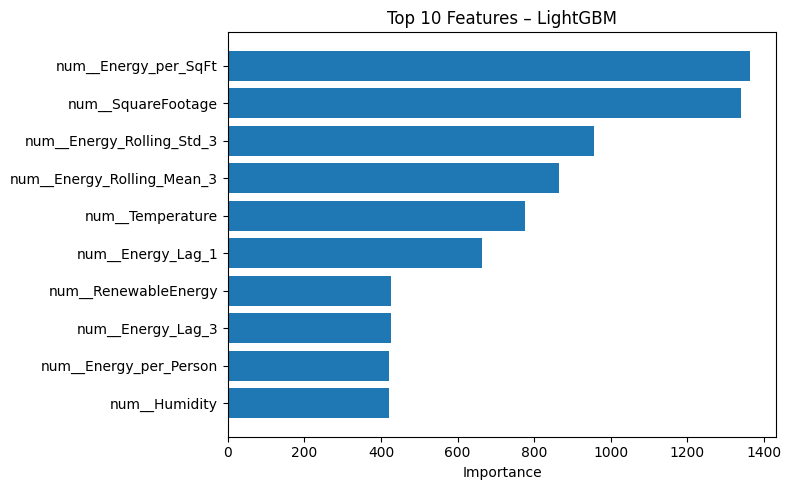

In [229]:
plt.figure(figsize=(8,5))
plt.barh(
    importance_df["Feature"].head(10)[::-1],
    importance_df["Importance"].head(10)[::-1]
)
plt.xlabel("Importance")
plt.title("Top 10 Features – LightGBM")
plt.tight_layout()
plt.show()


In [230]:

joblib.dump(lgb_pipeline, "lightgbm_energy_model.pkl")
print("Model saved successfully!")


Model saved successfully!


In [231]:
sample_1 = {
    "Temperature": 38,
    "Humidity": 70,
    "SquareFootage": 1800,
    "Occupancy": 4,
    "HVACUsage": "On",
    "LightingUsage": 1,
    "RenewableEnergy": 1.2,
    "Holiday": 0,
    "Is_Peak_Hour": 1,
    "Energy_per_Person": 5.5,
    "Idle_Energy": 2.1,
    "HVACUsage_bin": 1,
    "Temp_HVAC_Interaction": 38,
    "Humidity_HVAC_Interaction": 70,
    "Energy_per_SqFt": 0.012,
    "Renewable_Ratio": 0.15,
    "Energy_Lag_1": 22,
    "Energy_Lag_3": 20,
    "Energy_Rolling_Mean_3": 21,
    "Energy_Rolling_Std_3": 1.2
}


In [232]:
print(test_df.dtypes)
print(test_df.head())


Temperature                    int64
Humidity                       int64
SquareFootage                  int64
Occupancy                      int64
HVACUsage                     object
LightingUsage                  int64
RenewableEnergy              float64
Holiday                        int64
Is_Peak_Hour                   int64
Energy_per_Person            float64
Idle_Energy                  float64
HVACUsage_bin                  int64
Temp_HVAC_Interaction          int64
Humidity_HVAC_Interaction      int64
Energy_per_SqFt              float64
Renewable_Ratio              float64
Energy_Lag_1                   int64
Energy_Lag_3                   int64
Energy_Rolling_Mean_3          int64
Energy_Rolling_Std_3         float64
dtype: object
   Temperature  Humidity  SquareFootage  Occupancy HVACUsage  LightingUsage  \
0           38        70           1800          4        On              1   

   RenewableEnergy  Holiday  Is_Peak_Hour  Energy_per_Person  Idle_Energy  \
0         

In [233]:
model = joblib.load("lightgbm_energy_model.pkl")
test_df = pd.DataFrame([sample_1])  # change to sample_2 or sample_3


prediction = model.predict(test_df)

print("Predicted Energy Consumption:", prediction[0],"kWh")

Predicted Energy Consumption: 74.38234136258677 kWh


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
